**Mohamad Ali Ghaddar**

# Neural Network from scratch

In this project, you will build a neural network from scractch. You will be designing the network, implementing feedforward and backpropagation, training the network and analyzing the results.
Code cells for preparing the data and displaying the results are provided for you to use. Feel free to modify these cells if you wish to explore the data differently and provide other visual representations for better understanding and analysis.

## Problem description

In this project, we will predict the demand on bikes for a bike rental system, where the bikes are shared among different users. It is beneficial for the bike rental company to predict the number of bikes that it needs to make available for its customers, to avoid any shortage or customer dissatisfaction.

We will be using the Bike Sharing Dataset provided by the UCI Machine Learning laboratory: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

(optional reading:  Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg. https://link.springer.com/article/10.1007/s13748-013-0040-3)

## Exploring the dataset

The dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. In this project, we will only use the hourly count as provided in the file "hour.csv".

Let us first import the dataset and display the first few records.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_path = 'hour.csv'
records = pd.read_csv(data_path)
records.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Preparing the data

The dataset contains several categorical* variables. Let us convert these variables to one-hot encoding, and concatenate the result to our data. These variables will be later removed, while only the one-hot encoding will be kept for later use.

\*NOTE: A categorical variable is a variable that can take one value within a limit set of possible values.
For example, *GENDER* could be *Male*, *Female*, or *Undeclared*. Converting this variable to one-hot encoding would result in the following:
![image.png](attachment:image.png)

In [ ]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(records[each], prefix=each, drop_first=False)
    records = pd.concat([records, dummies], axis=1)
records.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0,0,0,0,0,0,0,0,0,1


Next, we will remove all variables that we won't be using, including categorical variables.

In [ ]:
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr', 'casual', 'registered']
data = records.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,16,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,32,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In the next cell, we will normalize our continuous variables such that they have a mean equal to 0 and a standard deviation of 1. This makes training the network easier. Scaling factors will be saved so we can go backwards when we use the network for predictions.

In [ ]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
data.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.956312,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.823998,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.868103,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.972851,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-1.039008,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Training and Testing data

We will put aside the data corresponding to the last 30 days, which will be later used for testing. The neural network will be trained on all the dataset except the testing data. Once trained, testing data will be used to assess the network performance when working with new unseen data.
The records of the last 60 days in the remaining training data will be used for validation. Validation is similar to testing, but used after each training pass to monitor the NN performance with unseen data compared to training data.

In [ ]:
# Save the last 30 days as test data
test_data = data[-30*24:] #not all days contain 24 records, this is only an approximate number of days

# Remove the test data from the dataset
data = data[:-30*24]

# Separate the data into features (input vectors) and targets (labels)
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# Separate the last 60 days records of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Loss Function

Now, let's define the Mean Square Error as the loss function.

In [ ]:
# Define the Mean Square Error

def MSE(y, Y):
    ''' Arguments
        ---------
        Y: predictions
        y: labels
    '''
    return np.mean((y-Y)**2)


## Design your neural network

Our neural network will consist of an input layer, an output layer, and one hidden layer.
![image.png](attachment:image.png)

The number of nodes at the input layer depends on the number of features in our feature vector. At the output layer, we only have one node that returns the count of bike shares. The number of nodes within the hidden layers will be left for you to determine.

Nodes within the hidden layer use the sigmoid function for activation. The output layer has only one node, and its output is the same as its input (i.e. the activation function at the output node is $f(x)=x$, which you will need to take into consideration in your backpropagation algorithm).

You will have to (1) define the sigmoid function, (2)implement feedforward in the train method as well as in the run method, and (3) implement the backpropagation algorithm.

Progress: 100.0% ... Training loss: 0.082 ... Validation loss: 0.194

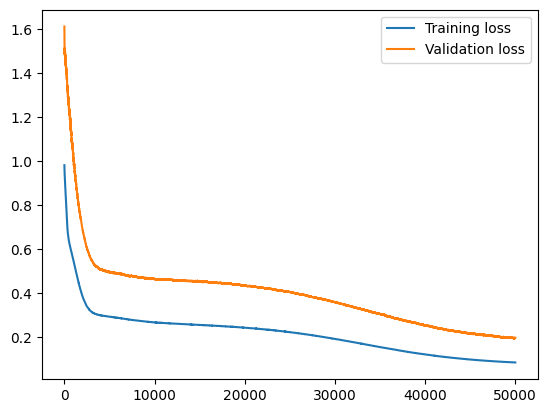

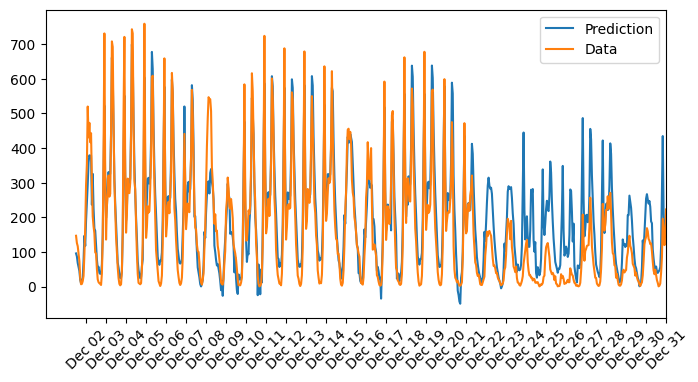

In [ ]:
import sys
import importlib
import my_neural_network
importlib.reload(my_neural_network)
from my_neural_network import NeuralNetwork
from my_neural_network import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 256 records from the training data set
    batch = np.random.choice(train_features.index, size=256)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']

    network.train(X, y)

    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()

    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(records.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)



## Analyze your results

In your opinion, how good is your model? When does it succeed and when does it fail?
Try to understand and explain your model performance.

**The training loss (0.082) appears to be very low and relatively stable. This suggests that the model is able to fit the training data well.**

**The validation loss (0.194) appears to be higher than the training loss. This is a common phenomenon known as overfitting. It occurs when the model learns the training data too well, including the noise and irregularities, and fails to generalize well to unseen data.**

**For the comparison between the prediction adn data, the model predicted some of the data correctly (around 65%) but after dec 21 it appears that the data predicted is far larger than the actual data.**

**The model succeeded in learning the data and it succeeded in the prediction pre dec 21, but failed to predict correctly for the rest of the month.**

# Project 1: Part 2: Using Pytorch

## Import libraries

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import importlib
import my_neural_network
importlib.reload(my_neural_network)
from my_neural_network import NeuralNetwork
from my_neural_network import iterations, learning_rate, hidden_nodes, output_nodes

## Exploring the dataset

## Importing the data

In [ ]:
data_path = 'hour.csv'
records = pd.read_csv(data_path)

## Preparing the data

In [ ]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(records[each], prefix=each, drop_first=False)
    records = pd.concat([records, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr', 'casual', 'registered']
data = records.drop(fields_to_drop, axis=1)

quant_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean) / std

## Training and Testing data

In [ ]:
test_data = data[-30*24:]
data = data[:-30*24]

target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1).values, data[target_fields].values
test_features, test_targets = test_data.drop(target_fields, axis=1).values, test_data[target_fields].values

## Convert the data to pytorch sensors

In [ ]:
X_train = torch.from_numpy(features).type(torch.FloatTensor)
y_train = torch.from_numpy(targets).type(torch.FloatTensor)
X_test = torch.from_numpy(test_features).type(torch.FloatTensor)
y_test = torch.from_numpy(test_targets).type(torch.FloatTensor)

## Define the neural network architecture using PyTorch

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.hidden(x))
        x = self.output(x)
        return x

## Instantiate & split the data

In [ ]:
input_size = X_train.shape[1]
output_size = 1

model = NeuralNetwork(input_size, hidden_nodes, output_nodes)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

split = int(0.8 * len(X_train))
train_features, train_targets = X_train[:split], y_train[:split]
val_features, val_targets = X_train[split:], y_train[split:]

## Training the model

In [ ]:
train_losses = []
val_losses = []
for epoch in range(iterations):
    optimizer.zero_grad()
    output = model(train_features)
    loss = criterion(output, train_targets)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        val_output = model(val_features)
        val_loss = criterion(val_output, val_targets)
        val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * epoch / float(iterations)) \
                         + "% ... Training loss: " + str(loss.item())[:5] \
                         + " ... Validation loss: " + str(val_loss.item())[:5])
        sys.stdout.flush()

Progress: 99.8% ... Training loss: 0.053 ... Validation loss: 0.158

## Plot & Evaluate the results

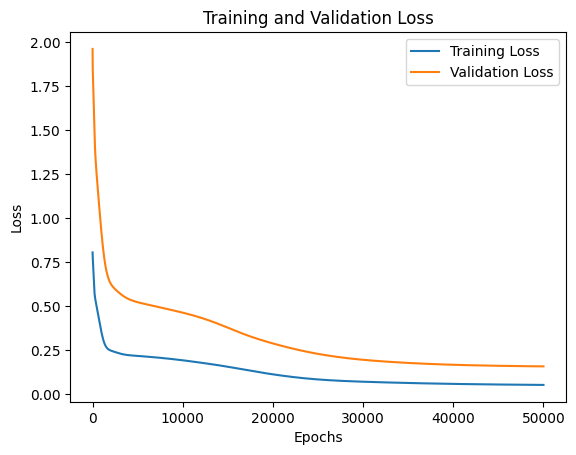

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.1983


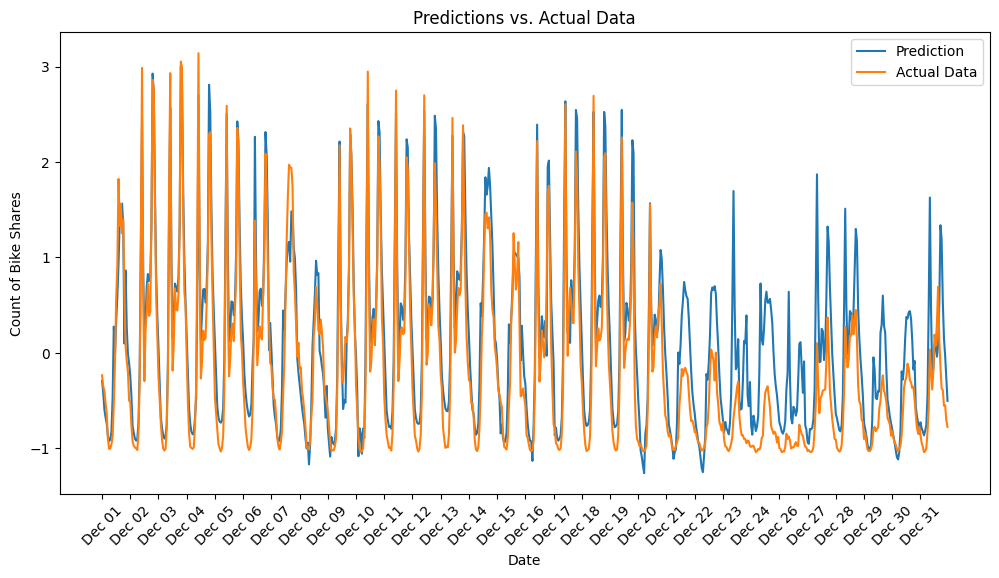

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_pred.numpy(), label='Prediction')
plt.plot(y_test.numpy(), label='Actual Data')
plt.xlabel('Date')
plt.ylabel('Count of Bike Shares')
plt.title('Predictions vs. Actual Data')
date_range = pd.date_range(start='12-01-2012', end='12-31-2012', freq='D')
plt.xticks(np.arange(0, len(test_data), 24), pd.to_datetime(records.iloc[test_data.index]['dteday'])[::24].dt.strftime('%b %d'), rotation=45)
plt.legend()
plt.show()

## Conclusion

**Using Pytorch we notice that the results appear to be better than using numpy, because with pytorch we had less validation loss 0.053 (compared to 0.082) and less validation loss 0.158 (compared to 0.194), as for the predictions we notice the same spike near december 21 where the predictions are above the actual data (which means the model predicted good enough for the first 19 days only, therefore it is not a good model).**